In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
def load_trials_df(version: int):
    filename = f"grid_data_{version:02d}.yaml"

    with open(filename, "r") as f:
        data = yaml.safe_load(f)

    trials = []

    for trial in data["trials"].values():
        for k, v in trial["config"].items():
            trial[f"config.{k}"] = v
        del trial["config"]

        for k, v in trial["metrics"].items():
            trial[f"metrics.{k}"] = v
        del trial["metrics"]

        trials.append(trial)

    return pd.DataFrame(trials)

trials_df = load_trials_df(version=1)
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                864 non-null    int64  
 1   n_samples                            864 non-null    int64  
 2   started_at                           864 non-null    object 
 3   finished_at                          864 non-null    object 
 4   duration                             864 non-null    float64
 5   error                                709 non-null    object 
 6   config.Nt                            864 non-null    int64  
 7   config.Nin                           864 non-null    int64  
 8   config.p_flip                        864 non-null    float64
 9   config.K                             864 non-null    int64  
 10  config.Nlayer                        864 non-null    int64  
 11  config.Nhidden                  

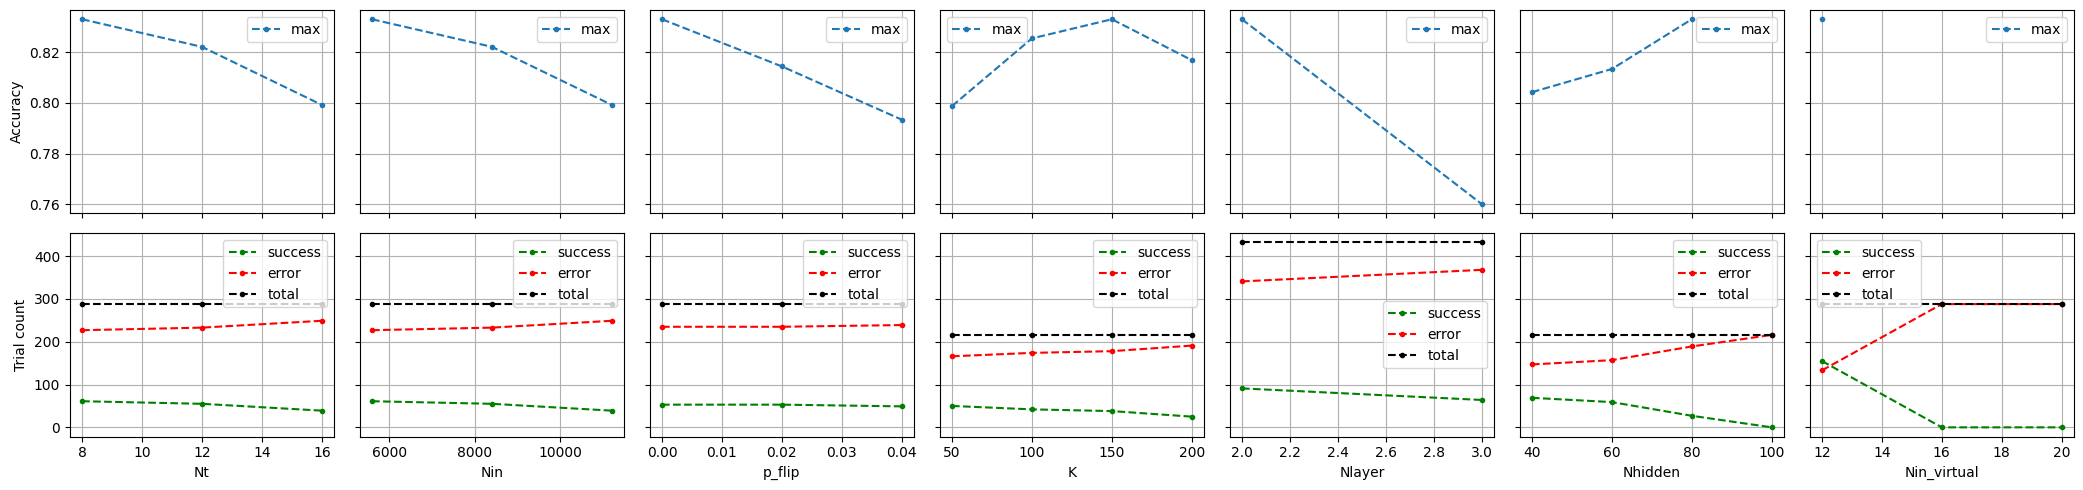

In [13]:
def plot_config_dependency(df, agg_funcs=("max",), agg_kwargs=dict(numeric_only=True)):
    config_cols = [col for col in df.columns if col.startswith("config.")]

    fig, axs = plt.subplots(2, len(config_cols), figsize=(3 * len(config_cols), 5), sharey="row", sharex="col", squeeze=False)

    for (agg_ax, count_ax), config_col in zip(axs.T, config_cols):
        grouped = df.groupby(config_col)

        for agg_func in agg_funcs:
            agg_df = grouped.aggregate(agg_func, **agg_kwargs)
            
            agg_df.plot(
                ax=agg_ax,
                y="metrics.acc_mean",
                marker=".",
                linestyle="--",
                label=agg_func,
            )

        grouped.count().plot(
            ax=count_ax,
            y="metrics.acc_mean",
            marker=".",
            linestyle="--",
            label="success",
            color="green",
        )
        grouped.count().plot(
            ax=count_ax,
            y="error",
            marker=".",
            linestyle="--",
            label="error",
            color="red",
        )
        grouped.size().plot(
            ax=count_ax,
            marker=".",
            linestyle="--",
            label="total",
            color="black",
        )

        agg_ax.set_ylabel("Accuracy")
        agg_ax.grid()
        agg_ax.legend()

        count_ax.set_xlabel(config_col.removeprefix("config."))
        count_ax.set_ylabel("Trial count")
        count_ax.grid()
        count_ax.legend()

    plt.tight_layout()
    plt.show()

plot_config_dependency(trials_df)

## Best trials

In [6]:
trials_df.sort_values("metrics.acc_mean", ascending=False).head(10)

,index,n_samples,started_at,finished_at,duration,error,config.Nt,config.Nin,config.p_flip,config.K,config.Nlayer,config.Nhidden,config.Nin_virtual,metrics.acc_mean,metrics.acc_std,metrics.acc_ord_mean,metrics.acc_ord_std,metrics.activity_mean,metrics.activity_std,metrics.activity_first_mean,metrics.activity_first_std,metrics.loss_mean,metrics.loss_std,metrics.loss_ord_mean,metrics.loss_ord_std,metrics.perf.compilation_time_mean,metrics.perf.compilation_time_std,metrics.perf.optim_init_time_mean,metrics.perf.optim_init_time_std,metrics.perf.phi0_init_time_mean,metrics.perf.phi0_init_time_std,metrics.perf.weights_init_time_mean,metrics.perf.weights_init_time_std,metrics.silent_neurons_mean,metrics.silent_neurons_std,metrics.silent_neurons_first_mean,metrics.silent_neurons_first_std
162,163,3,2024-08-28_22-31-08_896511,2024-08-28_22-32-06_129337,57.232826,None,8,5600,0.00,150,2,80,12,0.832983,0.017176,0.379630,0.034684,0.299988,0.034494,0.297042,0.033628,0.857134,0.093494,2.944813,0.012133,0.000634,0.000009,0.003117,0.000698,0.000699,0.000036,0.003957,0.002019,0.154167,0.065617,0.154167,0.065617
153,154,3,2024-08-28_22-24-28_902840,2024-08-28_22-25-21_326861,52.424021,None,8,5600,0.00,100,2,80,12,0.825418,0.016692,0.423051,0.053489,0.289913,0.034166,0.286622,0.033211,0.754109,0.071067,2.934056,0.016666,0.000639,0.000006,0.003139,0.000802,0.000827,0.000168,0.002538,0.001077,0.129167,0.064818,0.133333,0.067956
154,155,3,2024-08-28_22-25-21_608192,2024-08-28_22-26-18_314592,56.706400,None,12,8400,0.00,100,2,80,12,0.822094,0.019648,0.390407,0.038426,0.280794,0.029809,0.278894,0.029313,0.789580,0.042331,2.942218,0.009315,0.000647,0.000018,0.003742,0.001434,0.000625,0.000031,0.001334,0.000359,0.125000,0.017678,0.129167,0.015590
163,164,3,2024-08-28_22-32-06_430933,2024-08-28_22-33-04_903509,58.472576,None,12,8400,0.00,150,2,80,12,0.818179,0.011466,0.438165,0.049131,0.289965,0.038174,0.287538,0.037113,0.776070,0.056312,2.932559,0.024456,0.000627,0.000006,0.004574,0.002012,0.001565,0.001276,0.001221,0.000072,0.120833,0.031180,0.120833,0.031180
171,172,3,2024-08-28_22-38-00_600596,2024-08-28_22-39-06_061137,65.460541,None,8,5600,0.00,200,2,80,12,0.816845,0.018627,0.416081,0.024766,0.272089,0.031322,0.269506,0.030672,0.749774,0.074479,2.942631,0.012251,0.000621,0.000003,0.003261,0.000926,0.002562,0.001442,0.001770,0.000993,0.162500,0.053033,0.162500,0.053033
166,167,3,2024-08-28_22-34-25_632685,2024-08-28_22-35-21_898022,56.265337,None,12,8400,0.02,150,2,80,12,0.814377,0.020278,0.417761,0.049293,0.271353,0.027809,0.269386,0.027029,0.782934,0.035590,2.937955,0.018934,0.000630,0.000007,0.004581,0.002056,0.001736,0.001347,0.001373,0.000403,0.179167,0.051370,0.179167,0.051370
100,101,3,2024-08-28_21-42-57_914530,2024-08-28_21-43-56_141811,58.227281,None,12,8400,0.00,200,2,60,12,0.813354,0.018340,0.368216,0.002713,0.255176,0.007640,0.253996,0.007742,0.755970,0.013222,2.961259,0.000405,0.000637,0.000009,0.002883,0.000599,0.000586,0.000015,0.001320,0.000189,0.144444,0.034247,0.144444,0.034247
157,158,3,2024-08-28_22-27-48_154652,2024-08-28_22-28-42_695588,54.540936,None,12,8400,0.02,100,2,80,12,0.811845,0.020641,0.449546,0.053237,0.271640,0.037520,0.269324,0.036547,0.760311,0.062045,2.929702,0.021008,0.000636,0.000008,0.003590,0.001248,0.000620,0.000039,0.001135,0.000037,0.195833,0.069472,0.195833,0.069472
165,166,3,2024-08-28_22-33-26_799090,2024-08-28_22-34-25_326537,58.527447,None,8,5600,0.02,150,2,80,12,0.811044,0.007125,0.424822,0.026291,0.275371,0.015942,0.272917,0.015646,0.816174,0.052207,2.945880,0.005826,0.000630,0.000009,0.003151,0.000756,0.002099,0.001029,0.002337,0.000880,0.145833,0.032808,0.145833,0.032808
91,92,3,2024-08-28_21-35-08_008567,2024-08-28_21-35-58_965400,50.956833,None,12,8400,0.00,150,2,60,12,0.806145,0.010872,0.340525,0.050013,0.255865,0.010205,0.254502,0.010089,0.791636,0.015298,2.960672,0.014562,0.000633,0.000008,0.003607,0.001130,0.000616,0.000015,0.001417,0.000297,0.161111,0.015713,0.161111,0.015713


In [12]:
best_trial = trials_df.loc[trials_df["metrics.acc_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial)
print()
print("===== BEST CONFIG =====")
best_config = {
    k.removeprefix("config."): v.item()
    for k, v in best_trial.items()
    if isinstance(k, str) and k.startswith("config.")
}
best_config

===== BEST TRIAL =====
index                                                         163
n_samples                                                       3
started_at                             2024-08-28_22-31-08_896511
finished_at                            2024-08-28_22-32-06_129337
duration                                                57.232826
error                                                        None
config.Nt                                                       8
config.Nin                                                   5600
config.p_flip                                                 0.0
config.K                                                      150
config.Nlayer                                                   2
config.Nhidden                                                 80
config.Nin_virtual                                             12
metrics.acc_mean                                         0.832983
metrics.acc_std                                      

{'Nt': 8,
 'Nin': 5600,
 'p_flip': 0.0,
 'K': 150,
 'Nlayer': 2,
 'Nhidden': 80,
 'Nin_virtual': 12}